# TMD 2024
### Lucas Poma
## Trabajo Practico 1

## Imports

In [ ]:
library(ggplot2)
library(rpart)
library(class)
library(MASS)
install.packages("caret")
library(caret)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Ejercicio 1

In [ ]:
diagonales <- function(n, d, C) {
  half <- floor(n / 2)

  mClass0 <- rep(-1, d)
  mClass1 <- rep(1, d)
  covM <- diag(C^2 * d, d)

  class0 <- MASS::mvrnorm(n = half, mu = mClass0, Sigma = covM)
  class1 <- MASS::mvrnorm(n = n - half, mu = mClass1, Sigma = covM)

  labels0 <- matrix(0, nrow = half, ncol = 1)
  labels1 <- matrix(1, nrow = n - half, ncol = 1)

  data0 <- cbind(class0, labels0)
  data1 <- cbind(class1, labels1)

  data <- rbind(data0, data1)

  columns <- c(paste0("dim_", 1:d), "class")
  dataFrame <- as.data.frame(data)
  colnames(dataFrame) <- columns
  dataFrame$class <- as.factor(dataFrame$class)

  return(dataFrame)
}


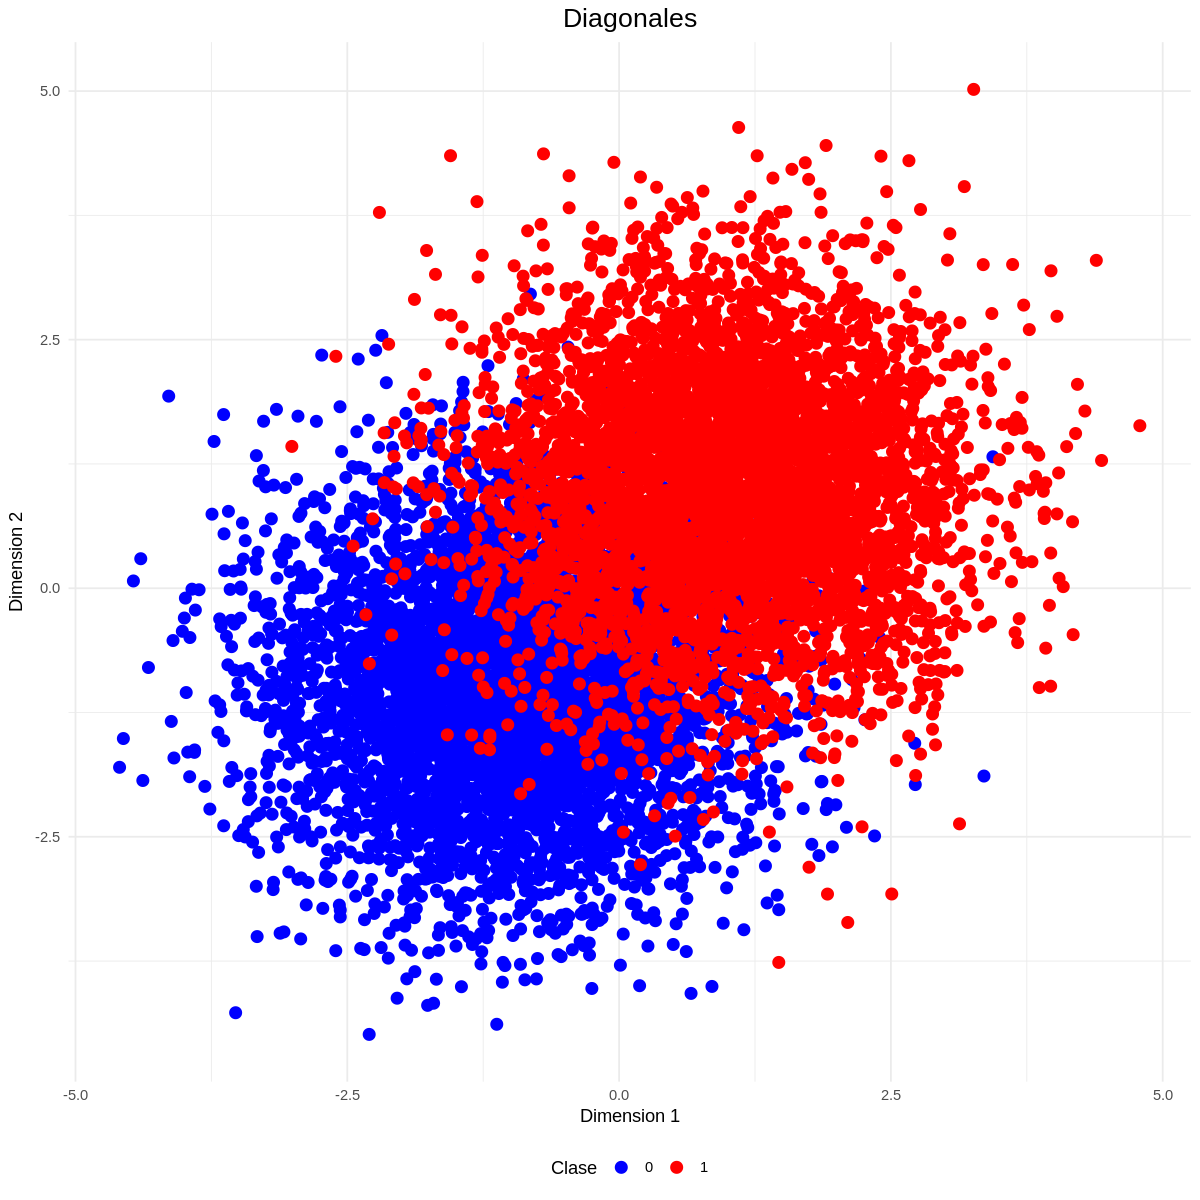

In [ ]:
data <- diagonales(n = 10000, d = 2, C = 0.78)
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data, aes(x = dim_1, y = dim_2, color = factor(class))) +
  geom_point(size = 3) +
  labs(title = "Diagonales", x = "Dimension 1", y = "Dimension 2") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red"), name = "Clase") +
  theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5, size = 16))

## Ejercicio 2

In [ ]:
espirales <- function(n) {
  half <- floor(n / 2)

  gen <- matrix(runif(n * 5, -1, 1), ncol = 2)
  inside_circle <- sqrt(gen[, 1]^2 + gen[, 2]^2) <= 1
  gen <- gen[inside_circle, ]

  rho <- sqrt(gen[, 1]^2 + gen[, 2]^2)
  theta <- atan2(gen[, 2], gen[, 1])

  in_curves <- sapply(1:4, function(i) {
    npi <- (2 * i) - 1
    rho_curve1 <- (theta + (npi - 1) * pi) / (4 * pi)
    rho_curve2 <- (theta + npi * pi) / (4 * pi)
    rho_curve1 <= rho & rho <= rho_curve2
  })

  class <- apply(in_curves, 1, any)
  class_labels <- ifelse(class, 0, 1)

  class0_points <- which(class_labels == 0)
  class1_points <- which(class_labels == 1)

  class0_sample <- sample(class0_points, half)
  class1_sample <- sample(class1_points, n - half)

  final_sample <- rbind(gen[class0_sample, ], gen[class1_sample, ])
  class_labels_final <- c(rep(0, half), rep(1, n - half))

  dataFrame <- as.data.frame(cbind(final_sample, class_labels_final))
  colnames(dataFrame) <- c('dim_1', 'dim_2', 'class')
  dataFrame$class <- as.factor(dataFrame$class)

  return(dataFrame)
}

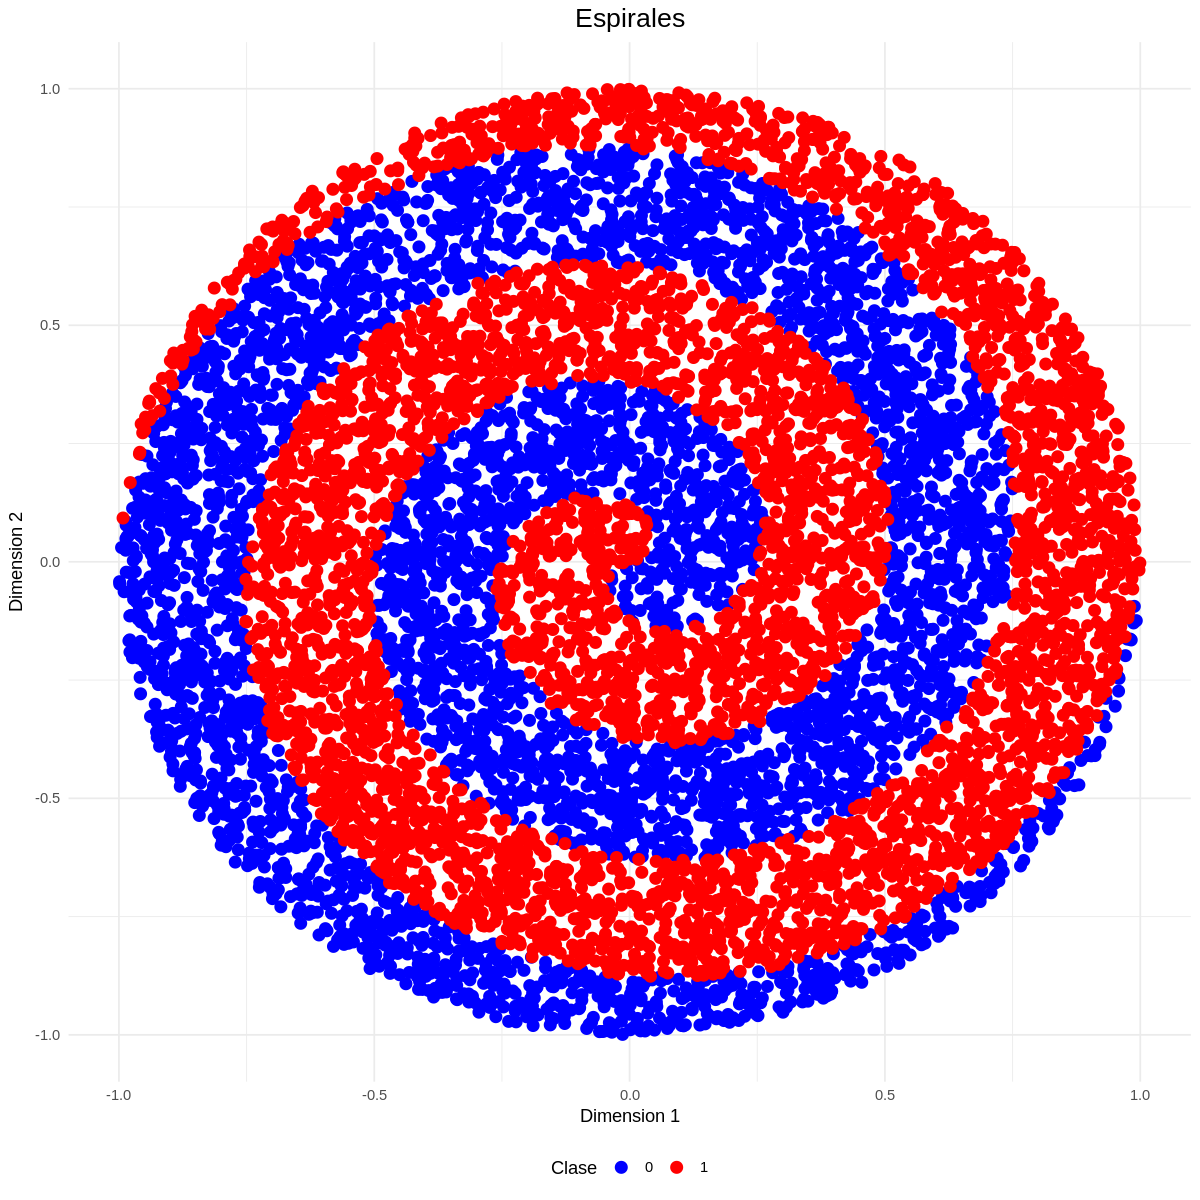

In [ ]:
data <- espirales(10000)
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data, aes(x = dim_1, y = dim_2, color = factor(class))) +
  geom_point(size = 3) +
  labs(title = "Espirales", x = "Dimension 1", y = "Dimension 2") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red"), name = "Clase") +
  theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5, size = 16))

## Ejercicio 3

In [ ]:
train_data <- espirales(300)
test_data <- espirales(10000)

In [ ]:
knn_model <- train(class ~ ., data = train_data, method = "knn", tuneGrid = expand.grid(k = 5))

knn_predictions <- predict(knn_model, test_data)

levels(knn_predictions) <- levels(test_data$class)

conf_matrix_knn <- confusionMatrix(knn_predictions, test_data$class)

knn_test_error <- 1 - conf_matrix_knn$overall["Accuracy"]
cat("Error de test (k-NN):", knn_test_error, "\n")

Error de test (k-NN): 0.1415 


In [ ]:
tree_model <- train(class ~ ., data = train_data, method = "rpart")

tree_predictions <- predict(tree_model, test_data)

levels(tree_predictions) <- levels(test_data$class)

conf_matrix_tree <- confusionMatrix(tree_predictions, test_data$class)

tree_test_error <- 1 - conf_matrix_tree$overall["Accuracy"]
cat("Error de test (Árbol de Decisión):", tree_test_error, "\n")

Error de test (Árbol de Decisión): 0.3631 


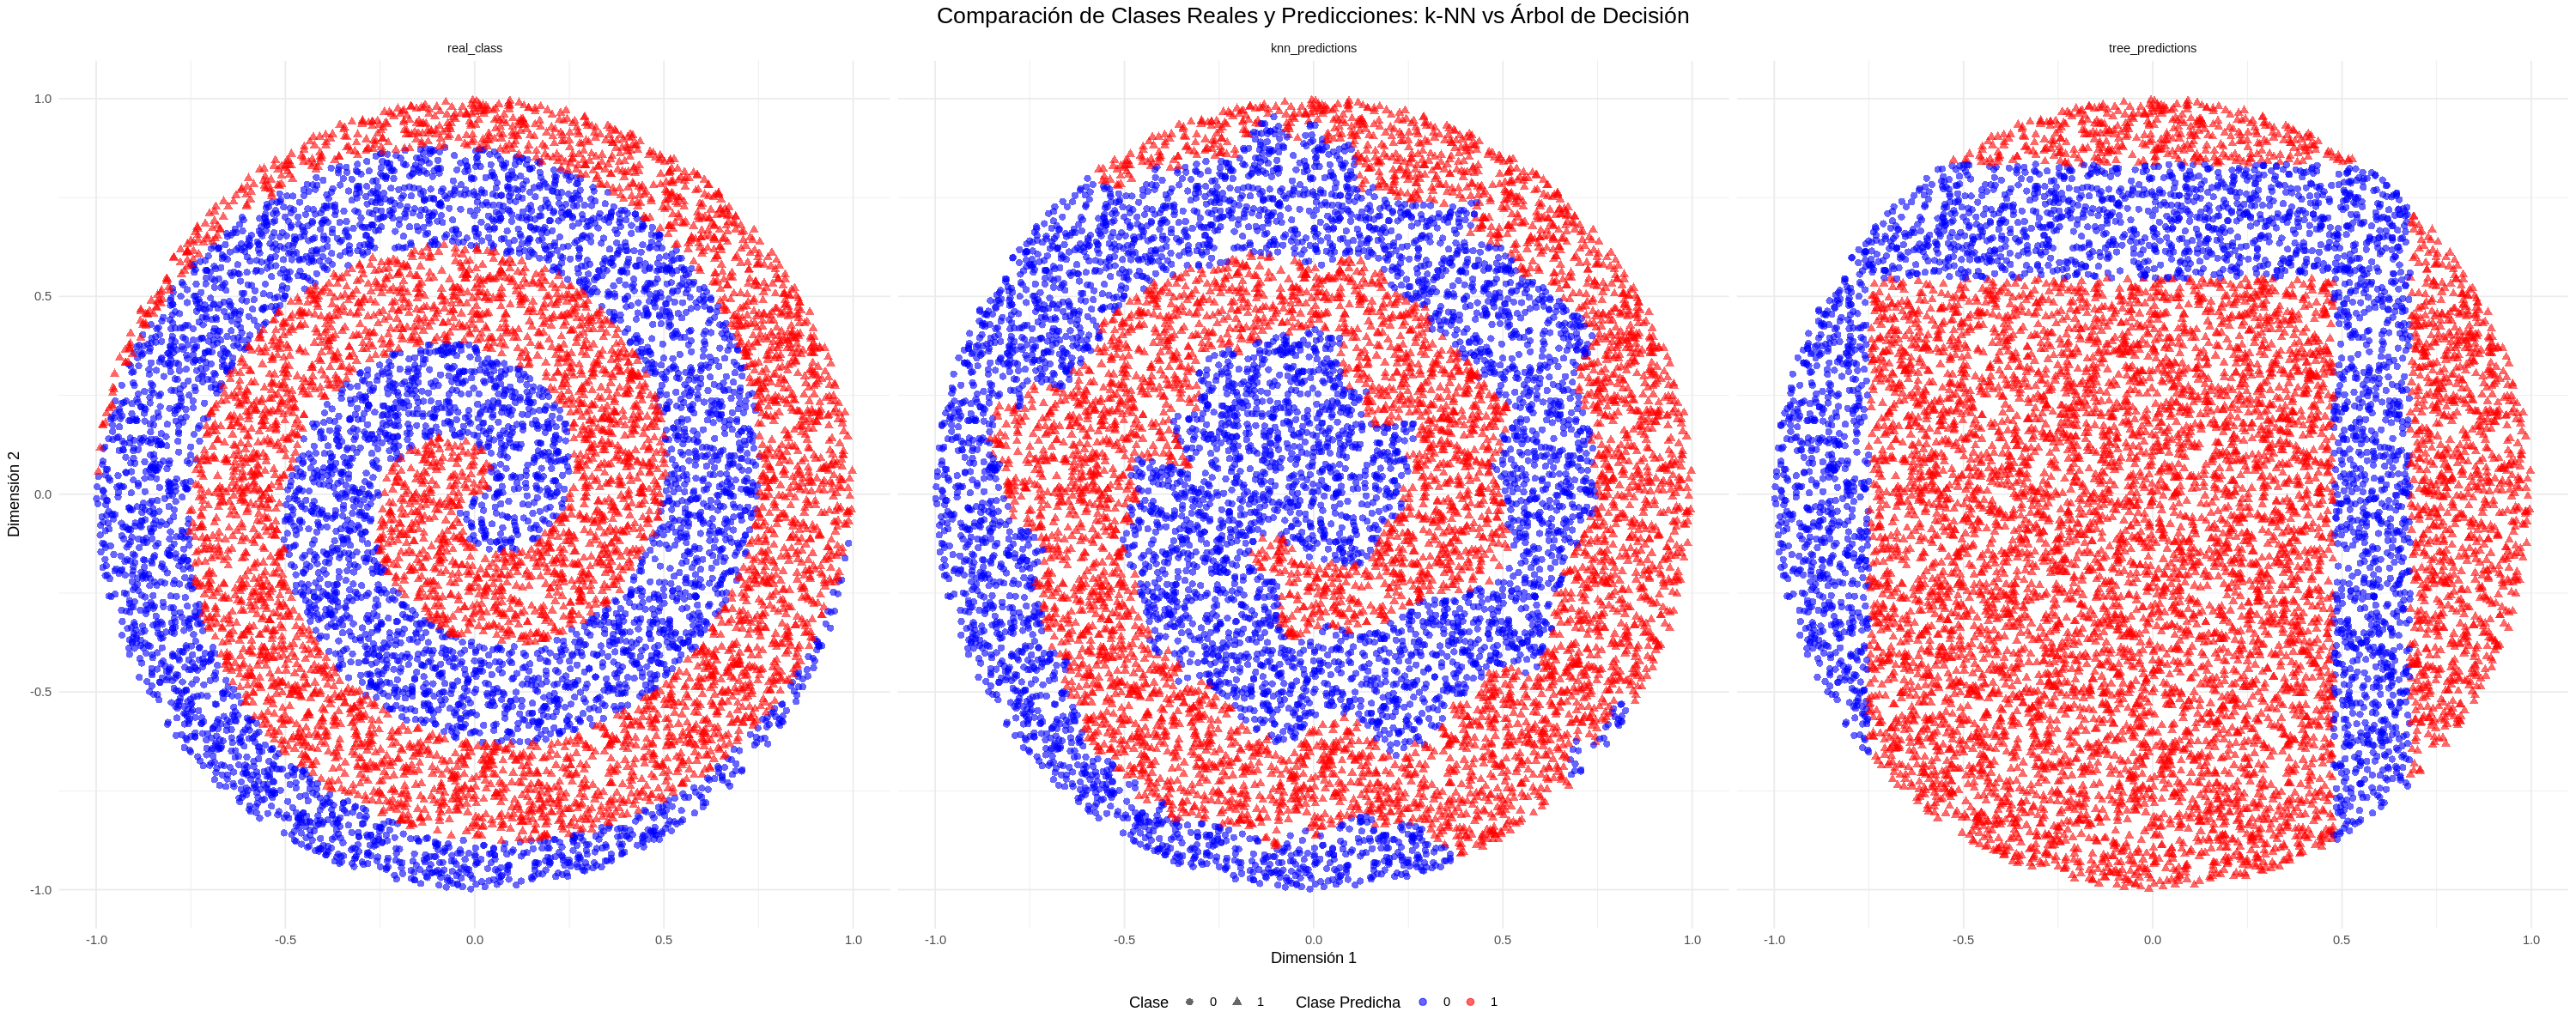

In [ ]:
test_data$knn_predictions <- knn_predictions
test_data$tree_predictions <- tree_predictions
test_data$real_class <- test_data$class

long_data <- reshape2::melt(test_data, id.vars = c("dim_1", "dim_2"),
                  measure.vars = c("real_class", "knn_predictions", "tree_predictions"),
                  variable.name = "model", value.name = "predicted_class")

options(repr.plot.width = 25, repr.plot.height = 10)

ggplot(long_data, aes(x = dim_1, y = dim_2, color = predicted_class, shape = predicted_class)) +
  geom_point(alpha = 0.6, size = 2) +
  facet_wrap(~model, ncol = 3) +
  labs(title = "Comparación de Clases Reales y Predicciones: k-NN vs Árbol de Decisión",
       x = "Dimensión 1", y = "Dimensión 2", color = "Clase Predicha", shape = "Clase") +
  theme_minimal() +
  scale_color_manual(values = c("blue", "red")) +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, size = 16))

In [ ]:
folds <- createFolds(train_data$class, k = 5, list = TRUE, returnTrain = FALSE)

In [ ]:
knn_errors <- c()

for (i in 1:5) {
  test_indices <- folds[[i]]

  train_indices <- setdiff(1:nrow(train_data), test_indices)

  train_fold <- train_data[train_indices, ]
  test_fold <- train_data[test_indices, ]

  knn_model <- train(class ~ ., data = train_fold, method = "knn", tuneGrid = expand.grid(k = 5))

  knn_predictions <- predict(knn_model, test_fold)

  conf_matrix <- confusionMatrix(knn_predictions, test_fold$class)
  knn_error <- 1 - conf_matrix$overall["Accuracy"]
  knn_errors <- c(knn_errors, knn_error)
}

knn_cv_error <- mean(knn_errors)
cat("Error promedio en validación cruzada (k-NN):", knn_cv_error, "\n")


Error promedio en validación cruzada (k-NN): 0.1766667 


In [ ]:
tree_errors <- c()

for (i in 1:5) {
  test_indices <- folds[[i]]

  train_indices <- setdiff(1:nrow(train_data), test_indices)

  train_fold <- train_data[train_indices, ]
  test_fold <- train_data[test_indices, ]

  tree_model <- train(class ~ ., data = train_fold, method = "rpart")

  tree_predictions <- predict(tree_model, test_fold)

  conf_matrix <- confusionMatrix(tree_predictions, test_fold$class)
  tree_error <- 1 - conf_matrix$overall["Accuracy"]
  tree_errors <- c(tree_errors, tree_error)
}

tree_cv_error <- mean(tree_errors)
cat("Error promedio en validación cruzada (Árbol de Decisión):", tree_cv_error, "\n")


Error promedio en validación cruzada (Árbol de Decisión): 0.4266667 


Podemos observar que la estimación utilizando 5-fold cross validation no difiere muy significativamente de los resultados obtenidos al utilizar el conjunto de test de manera directa. Esto sugiere que, incluso con la limitada cantidad de datos utilizados, la validación cruzada es un método decente para estimar el rendimiento de los modelos.

Tal como vimos en el curso de IAA, los árboles de decisión tienden a tener un rendimiento inferior en este tipo de problemas, mientras que el k-NN, como se muestra en el gráfico, logra aproximar con mayor precisión la forma de las curvas.